In [2]:
import pandas as pd
import warnings
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Loading first dataset

In [3]:
fake_news_path = 'datasets/raza/Fake.csv'
true_news_path = 'datasets/raza/True.csv'

fake_news_df = pd.read_csv(fake_news_path)
true_news_df = pd.read_csv(true_news_path)

In [4]:
fake_news_df['label'] = 'Fake'
true_news_df['label'] = 'True'

full_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)
# remove subject and date columns
full_df = full_df.drop(columns=['subject', 'date'])

In [5]:
full_df['label'].value_counts()
full_df.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Fake


## Loading second dataset

In [6]:
dataset_path = 'datasets/WELFake_Dataset.csv'
full_df2 = pd.read_csv(dataset_path)

In [7]:
full_df2['label'] = full_df2['label'].replace({0: 'Fake', 1: 'True'})
full_df2['label'].value_counts()
# drop rows with nAn values
full_df2 = full_df2.dropna()
# drop Unnamed: 0 column
full_df2 = full_df2.drop(columns=['Unnamed: 0'])

In [8]:
full_df2.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,True
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",True
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,Fake
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",True
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,True


## Combining datasets

In [9]:
combined_df = pd.concat([full_df, full_df2], ignore_index=True)
combined_df['label'].value_counts()


label
Fake    58509
True    57926
Name: count, dtype: int64

## Preparing vectorizer on combined dataset

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Combine 'title' and 'text' columns
combined_df['combined_text'] = combined_df['title'].fillna('') + ' ' + combined_df['text'].fillna('')

# Prepare the data
X = combined_df['combined_text']
y = combined_df['label']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf_vectorizer.fit(X)


## Training the first model

In [11]:
full_df['combined_text'] = full_df['title'].fillna('') + ' ' + full_df['text'].fillna('')
X = full_df['combined_text']
y = full_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical vectors using TF-IDF
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [12]:
# Train the Support Vector Machine (SVM) classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)

LinearSVC()

Accuracy on the Test Set: 0.9957


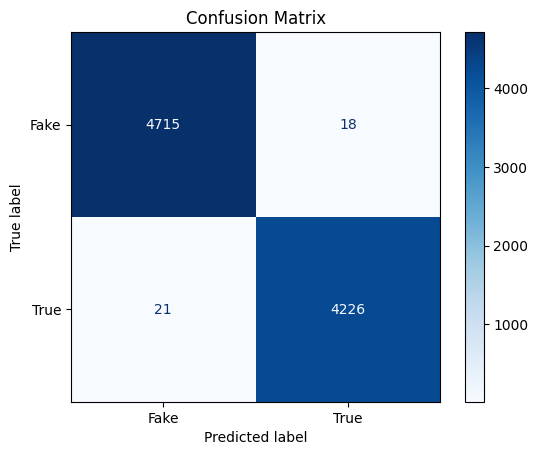


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.9962
Percentage of correctly predicted 'True' news: 0.9951

The 'Fake' class was predicted better than the 'True' class.

The 'True' class was predicted worse than the 'Fake' class.


In [13]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the Test Set: {accuracy:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")

## Train second model

In [14]:
full_df2['combined_text'] = full_df2['title'].fillna('') + ' ' + full_df2['text'].fillna('')

X2 = full_df2['combined_text']
y2 = full_df2['label']

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Convert text data into numerical vectors using TF-IDF
X_train_tfidf2 = tfidf_vectorizer.transform(X_train2)
X_test_tfidf2 = tfidf_vectorizer.transform(X_test2)

In [15]:
# Train the Support Vector Machine (SVM) classifier
svm_classifier2 = LinearSVC()
svm_classifier2.fit(X_train_tfidf2, y_train2)

LinearSVC()

Accuracy on the Test Set: 0.9600


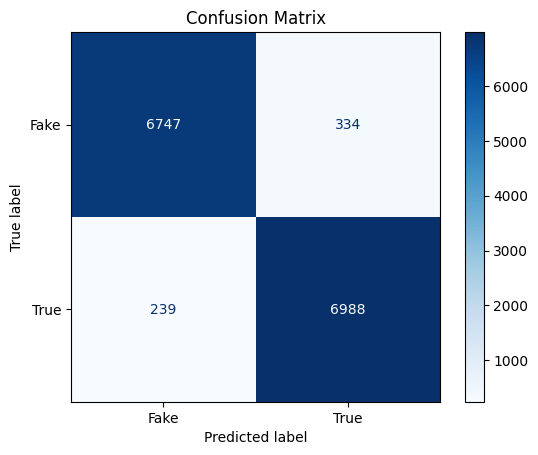


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.9528
Percentage of correctly predicted 'True' news: 0.9669

The 'True' class was predicted better than the 'Fake' class.

The 'Fake' class was predicted worse than the 'True' class.


In [16]:
# Make predictions on the test set
y_pred2 = svm_classifier2.predict(X_test_tfidf2)

# Calculate the accuracy
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy on the Test Set: {accuracy2:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test2, y_pred2, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")

## Trying the second dataset in the first model

Accuracy on the Test Set: 0.1692


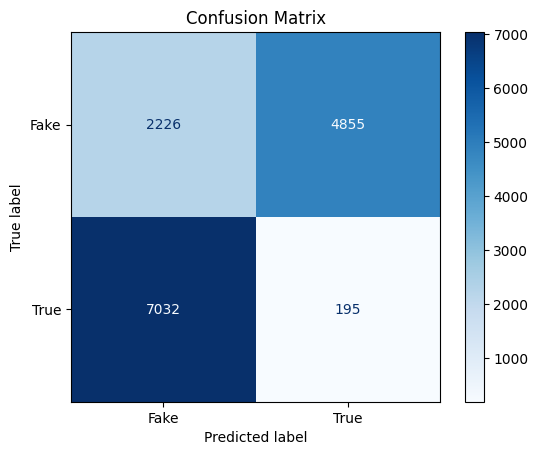


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.3144
Percentage of correctly predicted 'True' news: 0.0270

The 'Fake' class was predicted better than the 'True' class.

The 'True' class was predicted worse than the 'Fake' class.


In [17]:
# Make predictions on the test set
y_pred3 = svm_classifier.predict(X_test_tfidf2)

# Calculate the accuracy
accuracy3 = accuracy_score(y_test2, y_pred3)
print(f"Accuracy on the Test Set: {accuracy3:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test2, y_pred3, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")

## Trying the first dataset in the second model

Accuracy on the Test Set with second model: 0.0060


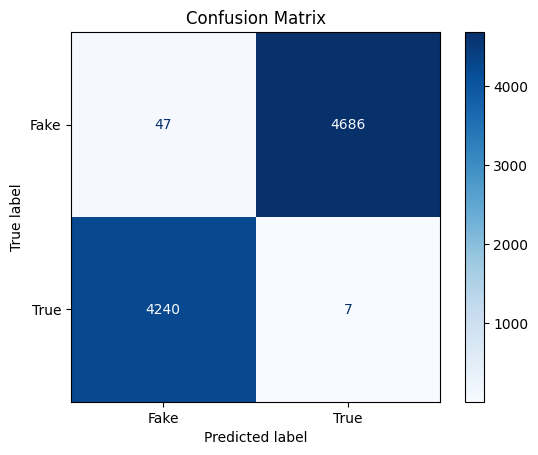


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.3144
Percentage of correctly predicted 'True' news: 0.0270

The 'Fake' class was predicted better than the 'True' class.

The 'True' class was predicted worse than the 'Fake' class.


In [18]:
# trying the first dataset with the second model
y_pred4 = svm_classifier2.predict(X_test_tfidf)
# Calculate the accuracy
accuracy4 = accuracy_score(y_test, y_pred4)
print(f"Accuracy on the Test Set with second model: {accuracy4:.4f}")

# Plot the confusion matrix
cm2 = confusion_matrix(y_test, y_pred4, labels=['Fake', 'True'])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Fake', 'True'])
disp2.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Analyze which class is predicted better and worse
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identify which class is predicted worse (higher misclassification rate)
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")



## Compare coeficients

In [19]:
import numpy as np

In [20]:
c1 = svm_classifier.coef_
print(c1)

c2 = svm_classifier2.coef_
print(c2)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Compute absolute difference
abs_diff = np.abs(c1 - c2)

# Flatten if needed (in case it's 2D with shape (1, n_features))
abs_diff = abs_diff.flatten()

# Get indices of top-k most different features
top_k = 40  # or any number you want
top_indices = np.argsort(abs_diff)[-top_k:][::-1]  # sort descending

# Get corresponding words and their differences
top_features = [(feature_names[i], abs_diff[i]) for i in top_indices]

# Print results
for word, diff in top_features:
    print(f"{word}: {diff:.4f}")


[[-0.68934903 -0.11092314  0.08476508 ...  0.          0.
   0.        ]]
[[-0.48248109 -0.04814181 -0.21956222 ...  0.02185318 -0.06545228
   0.        ]]
reuters: 38.5770
featured: 13.6529
image: 11.6087
getty: 10.0179
breaking: 9.5371
read: 9.3246
video: 9.1633
com: 7.9537
just: 6.1059
hillary: 6.0889
thursday: 5.9824
follow: 5.8351
wire: 5.8016
wednesday: 5.5066
flickr: 5.4739
watch: 5.4245
york: 5.1061
tuesday: 4.8989
washington: 4.7337
nyp: 4.7156
21wire: 4.7113
entire: 4.5994
wfb: 4.5705
twitter: 4.5505
monday: 4.5200
nov: 4.5139
october: 4.5115
friday: 4.4785
images: 4.3583
breitbart: 4.3408
21st: 4.2557
gop: 4.0765
nyt: 3.9918
pic: 3.9446
wow: 3.8641
factbox: 3.8400
photo: 3.8306
america: 3.7876
spokesman: 3.6810
dc: 3.6497


## Creating a common vocabulary based on the intersection of two datasets

In [22]:
import re

token_pattern = r"(?u)\b\w\w+\b"
token_pattern = re.compile(token_pattern)

vocab = full_df['combined_text'].apply(token_pattern.findall).apply(set).aggregate(lambda x: set.union(*x))
vocab2 = full_df2['combined_text'].apply(token_pattern.findall).apply(set).aggregate(lambda x: set.union(*x))


In [23]:
# Interseção entre os dois vocabulários
common_vocab = vocab.intersection(vocab2)

# Apenas para conferência:
vocab2_not_1 = vocab2 - vocab
print(f"Número de palavras em vocab2 que não estão em vocab: {len(vocab2_not_1)}")
print(f"Tamanho de vocab2: {len(vocab2)}")

lean_combined_df = combined_df.drop_duplicates()
print(f"Lean combined shape: {lean_combined_df.shape}, Original combined shape: {combined_df.shape}")

Número de palavras em vocab2 que não estão em vocab: 142838
Tamanho de vocab2: 296328
Lean combined shape: (102226, 4), Original combined shape: (116435, 4)


## Using the common vocabulary to create a new vectorizer and train a new model

In [24]:
# Prepare the data
X = combined_df['combined_text']
y = combined_df['label']


# Convertendo common_vocab em lista ordenada
vocab_list = sorted(common_vocab)

# Criar o vetor de TF-IDF com vocab fixo
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.7,
    vocabulary=vocab_list
)

# Ajustar o vectorizer ao combined_df
X_tfidf = tfidf_vectorizer.fit_transform(X)


In [25]:
full_df['combined_text'] = full_df['title'].fillna('') + ' ' + full_df['text'].fillna('')
X_full = full_df['combined_text']
y_full = full_df['label']
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Transformar com o vectorizer treinado
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [26]:
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)

LinearSVC()

## Evaluating the model on the second dataset

Accuracy on the Test Set: 0.1668


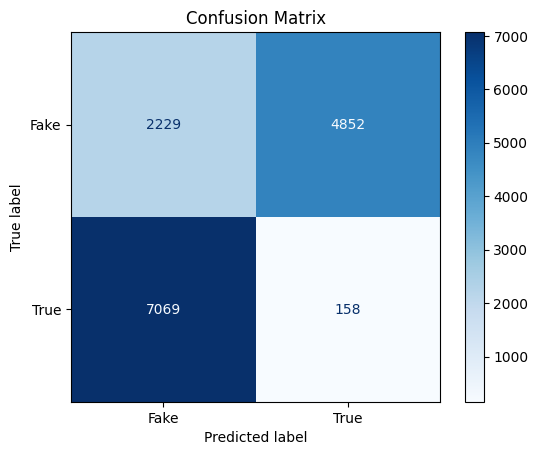


Class-wise Performance (based on normalized confusion matrix):
Percentage of correctly predicted 'Fake' news: 0.3148
Percentage of correctly predicted 'True' news: 0.0219

The 'Fake' class was predicted better than the 'True' class.

The 'True' class was predicted worse than the 'Fake' class.


In [27]:
X_test2_tfidf = tfidf_vectorizer.transform(X_test2)
y_pred = svm_classifier.predict(X_test2_tfidf)

accuracy2 = accuracy_score(y_test2, y_pred)
print(f"Accuracy on the Test Set: {accuracy2:.4f}")

cm = confusion_matrix(y_test2, y_pred, labels=['Fake', 'True'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Análise detalhada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, None]

fake_accuracy = cm_normalized[0, 0]
true_accuracy = cm_normalized[1, 1]

print("\nClass-wise Performance (based on normalized confusion matrix):")
print(f"Percentage of correctly predicted 'Fake' news: {fake_accuracy:.4f}")
print(f"Percentage of correctly predicted 'True' news: {true_accuracy:.4f}")

if fake_accuracy > true_accuracy:
    print("\nThe 'Fake' class was predicted better than the 'True' class.")
elif true_accuracy > fake_accuracy:
    print("\nThe 'True' class was predicted better than the 'Fake' class.")
else:
    print("\nThe prediction performance for both classes is similar.")

# Identificar qual classe foi pior
fake_misclassification = 1 - fake_accuracy
true_misclassification = 1 - true_accuracy

if fake_misclassification > true_misclassification:
    print("\nThe 'Fake' class was predicted worse than the 'True' class.")
elif true_misclassification > fake_misclassification:
    print("\nThe 'True' class was predicted worse than the 'Fake' class.")
else:
    print("\nThe misclassification rate is similar for both classes.")

In [28]:
coef = svm_classifier.coef_

feature_names = tfidf_vectorizer.get_feature_names_out()

top_k = 40  # Número de palavras mais relevantes
top_indices = np.argsort(np.abs(coef[0]))[-top_k:][::-1]  # Índices das palavras mais relevantes
top_features = [(feature_names[i], coef[0][i]) for i in top_indices]
for word, coef_value in top_features:
    print(f"{word}: {coef_value:.4f}")

reuters: 19.4138
said: 5.1525
read: -4.5180
breaking: -3.5734
video: -3.5565
featured: -3.5537
gop: -3.3250
image: -3.2774
just: -3.1576
getty: -2.9418
hillary: -2.4688
mr: -2.3586
factbox: 2.3465
rep: -2.2766
sen: -2.1586
washington: 2.1498
watch: -2.1161
com: -2.1078
21st: -2.0349
republican: 1.9006
pic: -1.8752
america: -1.8377
wire: -1.8084
entire: -1.7734
reportedly: -1.7621
didn: -1.7353
21wire: -1.7236
doesn: -1.6962
saying: 1.6812
daily: -1.6764
images: -1.6319
terror: -1.5959
showed: 1.5818
flickr: -1.5779
mail: -1.5757
american: -1.5541
thursday: 1.5440
https: -1.5218
rival: 1.5089
isis: -1.4610
